In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from TINTOlib.tinto import TINTO
from vit_pytorch.vit import ViT
from kan import *


import time
import gc
import copy
import traceback
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch.optim as optim
import torch


# 0. Set Device Cuda or CPU

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


## 0.1 Set Seeds

In [4]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# 1. Load Dataframe

In [5]:
diabetes = load_diabetes()
data = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
data['target'] = diabetes.target  # Add the target variable

## 2. Pre Process

In [6]:
def load_and_preprocess_data(df, images_folder, image_model, problem_type, batch_size=32, device='cuda'):
    """Loads, processes, and converts a dataset into PyTorch DataLoaders for a ViT + KAN model."""
    
    # Split dataset
    X_train, X_temp = train_test_split(df, test_size=0.2, random_state=SEED)
    X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=SEED)
    
    # Reset indices
    data_splits = {
        "train": X_train.reset_index(drop=True), 
        "val": X_val.reset_index(drop=True), 
        "test": X_test.reset_index(drop=True)
    }
    
    # Process images and numerical features
    num_features, img_paths, targets = {}, {}, {}

    for split, X_split in data_splits.items():
        split_folder = f"{images_folder}/{split}"
        os.makedirs(split_folder, exist_ok=True)

        # Ensure images and CSV files are generated
        image_model.fit_transform(X_split, split_folder) if split == "train" else image_model.transform(X_split, split_folder)

        # Validate CSV file existence
        csv_path = os.path.join(split_folder, f"{problem_type}.csv")
        if not os.path.exists(csv_path):
            print(f"Error: Missing CSV at {csv_path}. Available files: {os.listdir(split_folder)}")
            raise FileNotFoundError(f"Expected file {csv_path} not found. Ensure image_model generates it.")

        print(f"Loading {csv_path}...")
        img_df = pd.read_csv(csv_path)
        img_df["images"] = split_folder + "/" + img_df["images"]

        # Combine numerical data and images
        combined_df = pd.concat([img_df, X_split], axis=1)
        num_features[split] = combined_df.drop(columns=["values", "images", df.columns[-1]])
        img_paths[split] = img_df["images"]
        targets[split] = combined_df["values"]

    # Standardize numerical data
    scaler = StandardScaler()
    for split in ["train", "val", "test"]:
        num_features[split] = pd.DataFrame(scaler.fit_transform(num_features[split]) if split == "train" 
                                           else scaler.transform(num_features[split]), 
                                           columns=num_features[split].columns)

    # Convert images to tensors
    img_tensors = {split: torch.tensor(np.array([cv2.imread(img) for img in img_paths[split]]), 
                                       dtype=torch.float32, device=device).permute(0, 3, 1, 2) / 255.0
                   for split in ["train", "val", "test"]}
    
    # Get dataset properties
    attributes = num_features["train"].shape[1]
    channels, height, width = img_tensors["train"].shape[1:]
    imgs_shape = (channels, height, width)

    print("Images shape:", imgs_shape)
    print("Attributes:", attributes)

    # Convert numerical data and targets to tensors
    num_tensors = {split: torch.tensor(num_features[split].values, dtype=torch.float32, device=device)
                   for split in ["train", "val", "test"]}
    
    target_tensors = {split: torch.tensor(targets[split].values, dtype=torch.float32, device=device).reshape(-1, 1)
                      for split in ["train", "val", "test"]}

    # Create DataLoaders
    datasets = {split: TensorDataset(num_tensors[split], img_tensors[split], target_tensors[split]) 
                for split in ["train", "val", "test"]}
    
    data_loaders = {split: DataLoader(datasets[split], batch_size=batch_size, shuffle=(split == "train")) 
                    for split in ["train", "val", "test"]}

    return data_loaders["train"], data_loaders["val"], data_loaders["test"], attributes, imgs_shape


In [7]:
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, random_seed=SEED)
images_folder = "./HyKANImages/Diabetes"

In [9]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    data,
    images_folder=images_folder,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=16
)

Loading ./HyKANImages/Diabetes/train\regression.csv...
Loading ./HyKANImages/Diabetes/val\regression.csv...
Loading ./HyKANImages/Diabetes/test\regression.csv...
Images shape: (3, 20, 20)
Attributes: 10


# 3. Create Hybrid Model

In [11]:
class Model1(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size, device):
        super(Model1, self).__init__()
        self.device = device
        # ViT branch
        self.vit = ViT(
            image_size = imgs_shape,
            patch_size = patch_size,
            dim = 32,
            depth = 2,
            heads = 4,
            mlp_dim = 64,
            dropout = 0.1,
            emb_dropout = 0.1
        ).to(device)


        self.m_kan = KAN(
            width=[attributes, 10],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )

        self.final_kan = KAN(
            width=[32+10, 1],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )


    def forward(self, mlp_input, vit_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        vit_input = vit_input.to(self.device)
        
        vit_output = self.vit(vit_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        concat_output = torch.cat((kan_output, vit_output), dim=1)
        return self.final_kan(concat_output)

In [12]:
def try_create_model(model_class, patch_size, attributes, imgs_shape, device):
    try:
        model = model_class(attributes, imgs_shape[1:], patch_size, device)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}: {str(e)}")
        traceback.print_exc()
        return None

In [13]:
patch_size = 2
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape, device)  # Attempt to create Model1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model1


# 4. Compile and Train model

In [14]:
def compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=10, min_lr=1e-3, max_lr=1, device='cuda', weight_decay=1e-2):
    model = model
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    best_val_loss = float('inf')
    best_model = None
    best_epoch = 0

    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_rmse': [], 'val_rmse': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()

        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        for num_data, img_data, targets in train_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for num_data, img_data, targets in val_loader:
                num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                outputs = model(num_data, img_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1

        train_mse = mean_squared_error(train_targets, train_predictions)
        train_rmse = np.sqrt(train_mse)
        val_mse = mean_squared_error(val_targets, val_predictions)
        val_rmse = np.sqrt(val_mse)
        train_r2 = r2_score(train_targets, train_predictions)
        val_r2 = r2_score(val_targets, val_predictions)

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)

    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs}")
    print(f"Best Train Loss: {history['train_loss'][best_epoch-1]:.4f}, Best Val Loss: {history['val_loss'][best_epoch-1]:.4f}")
    print(f"Best Train MSE: {history['train_mse'][best_epoch-1]:.4f}, Best Val MSE: {history['val_mse'][best_epoch-1]:.4f}")
    print(f"Best Train RMSE: {history['train_rmse'][best_epoch-1]:.4f}, Best Val RMSE: {history['val_rmse'][best_epoch-1]:.4f}")

    # Save metrics to a file
    os.makedirs(f'logs/Regression/{dataset_name}/ViT+MLP/{model_name}', exist_ok=True)
    with open(f'logs/Regression/{dataset_name}/ViT+MLP/{model_name}/metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')
            
    # Save best model
    model_save_path = f"models/Regression/{dataset_name}/ViT+MLP/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics

def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for num_data, img_data, targets in data_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

In [15]:
dataset_name = 'diabetes'
name = f"TINTO"
metrics = compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model1", batch_size=32, epochs=40, min_lr=1e-4, max_lr=4e-3 , device='cuda', weight_decay=1e-2)

C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:816: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:826: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:827: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by o


Training completed in 532.07 seconds
Best model found at epoch 31/40
Best Train Loss: 2760.8820, Best Val Loss: 4507.6655
Best Train MSE: 2808.6846, Best Val MSE: 4523.1704
Best Train RMSE: 52.9970, Best Val RMSE: 67.2545
Best model saved to models/Regression/diabetes/ViT+MLP/diabetes_Model1/best_model.pth


In [21]:
metrics

{'train_loss': 2695.5791957689366,
 'train_mse': 2798.2485,
 'train_mae': 43.76227,
 'train_rmse': 52.898476,
 'train_r2': 0.4948774576187134,
 'val_loss': 4507.66552734375,
 'val_mse': 4523.1704,
 'val_mae': 53.77361,
 'val_rmse': 67.25452,
 'val_r2': 0.4281688928604126,
 'test_loss': 3752.16650390625,
 'test_mse': 3793.6548,
 'test_mae': 50.333622,
 'test_rmse': 61.59265,
 'test_r2': 0.3792951703071594,
 'min_lr': 0.0001,
 'max_lr': 0.004,
 'total_time': 532.0670211315155,
 'average_epoch_time': 13.301675528287888}

# 5.1 Plot Kan internal branch of the model

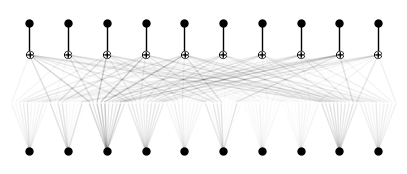

In [16]:
model1.m_kan.plot()

In [17]:
model1.m_kan.feature_score

tensor([0.1712, 0.2058, 0.4956, 0.2776, 0.1425, 0.1969, 0.0931, 0.0972, 0.3375,
        0.1894], device='cuda:0', grad_fn=<MeanBackward1>)

# 5.2 Plot Kan Final branch of the model

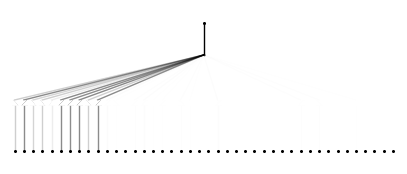

In [18]:
model1.final_kan.plot()

In [19]:
model1.final_kan.feature_score

tensor([6.4615e-02, 1.6329e-01, 5.6743e-02, 6.3960e-02, 2.3167e-02, 1.6440e-01,
        1.6097e-01, 1.6627e-01, 6.3981e-02, 1.6196e-01, 4.8827e-03, 1.7197e-03,
        1.2667e-05, 3.0599e-03, 3.7329e-03, 1.0640e-03, 1.7405e-03, 1.9986e-04,
        3.1895e-03, 1.0130e-03, 2.0356e-04, 8.7194e-05, 3.8478e-03, 3.5162e-05,
        6.0833e-05, 6.3233e-04, 3.6244e-05, 2.3018e-05, 2.1117e-04, 6.0914e-04,
        2.3660e-04, 2.0235e-03, 6.4284e-04, 2.4973e-03, 1.3593e-04, 1.7699e-04,
        1.4911e-04, 8.1302e-04, 1.8349e-04, 6.2523e-04, 1.5674e-05, 3.5696e-04],
       device='cuda:0', grad_fn=<MeanBackward1>)